#LOAD DATASET

In [6]:
# Upgrade gdown
!pip install --upgrade --no-cache-dir gdown

In [7]:
# Import library
import gdown
import zipfile, os
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Mounted at /content/drive


In [8]:
link = "https://drive.google.com/uc?id=1hT2uFMeHX9tE5kgTf-lx2I3S6psxykUd"
name_file = "mangga.zip"

gdown.download(link, name_file)

with zipfile.ZipFile(name_file, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(name_file)

Downloading...
From (original): https://drive.google.com/uc?id=1hT2uFMeHX9tE5kgTf-lx2I3S6psxykUd
From (redirected): https://drive.google.com/uc?id=1hT2uFMeHX9tE5kgTf-lx2I3S6psxykUd&confirm=t&uuid=5f601dbf-7d0e-496e-af7d-dd577111a2cd
To: /content/mangga.zip
100%|██████████| 179M/179M [00:04<00:00, 42.0MB/s]


In [9]:
train_dir = './mangga/train'
test_dir = './mangga/test'

In [10]:
base_dir = './mangga/train'
os.listdir(base_dir)

['Stem end Rot', 'Anthracnose', 'Alternaria', 'Healthy', 'Black Mould Rot']

In [11]:
print('number of Alternaria images :', len(os.listdir('./mangga/train/Alternaria')))
print('number of Anthracnose images :', len(os.listdir('./mangga/train/Anthracnose')))
print('number of Black Mould Rot :', len(os.listdir('./mangga/train/Black Mould Rot')))
print('number of Healthy images :', len(os.listdir('./mangga/train/Healthy')))
print('number of Stem end Rot images :', len(os.listdir('./mangga/train/Stem end Rot')))

number of Alternaria images : 960
number of Anthracnose images : 960
number of Black Mould Rot : 960
number of Healthy images : 960
number of Stem end Rot images : 960


In [12]:
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4800


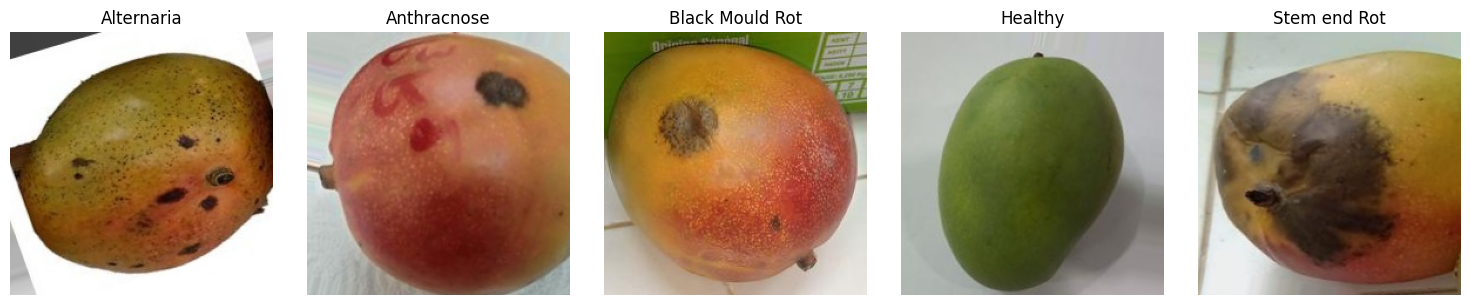

In [13]:
# Display sample images in each class

img_each_class = 1

classes = sorted(os.listdir(base_dir))

fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))

for i, c in enumerate(classes):
    img_name = os.listdir(os.path.join(base_dir, c))[0]
    img_path = os.path.join(base_dir, c, img_name)
    img = mpimg.imread(img_path)

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(c)

plt.tight_layout()
plt.show()


In [14]:
# Generator
train_generator = image_dataset_from_directory(
    directory=train_dir,
    image_size=(224, 224),
    seed=32,
    label_mode='int',
    subset='training',
    shuffle=True,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.2
)

val_generator = image_dataset_from_directory(
    directory=train_dir,
    image_size=(224, 224),
    seed=32,
    label_mode='int',
    subset='validation',
    shuffle=True,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.2
)

test_generator = image_dataset_from_directory(
    directory=test_dir,
    image_size=(224, 224),
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)


Found 4800 files belonging to 5 classes.
Using 3840 files for training.
Found 4800 files belonging to 5 classes.
Using 960 files for validation.
Found 1200 files belonging to 5 classes.


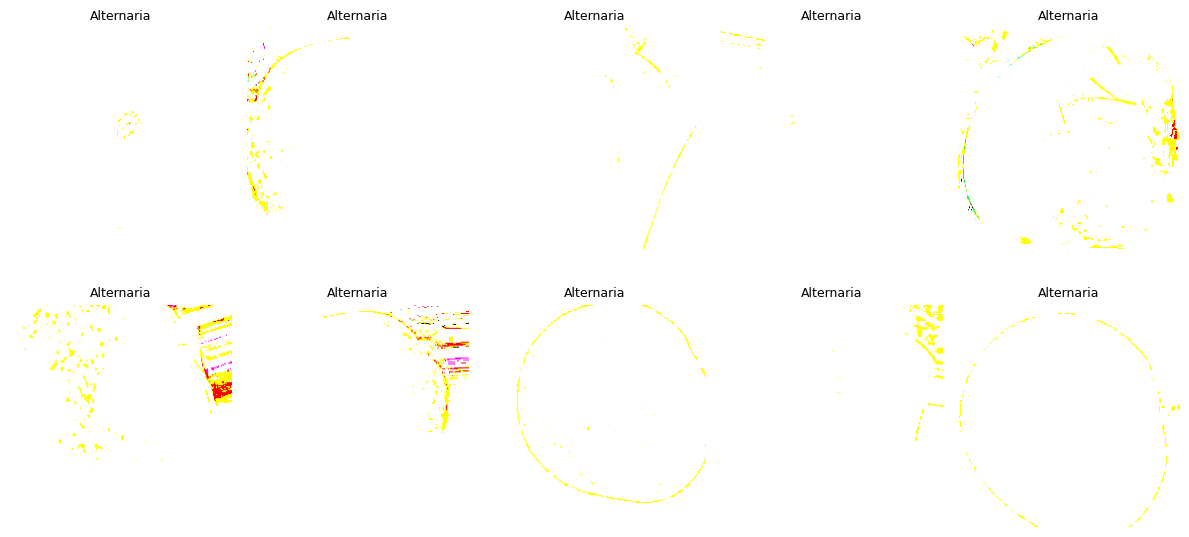

In [15]:
train_iterator = iter(train_generator)

augmented_images, labels = next(iter(train_generator))

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = augmented_images[i].numpy()

    img = (img * 255).clip(0, 255).astype("uint8")

    plt.imshow(img)
    class_index = labels[i].numpy().argmax()
    plt.title(train_generator.class_names[class_index], fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
validation_split=0.2
train_class_counts = {}
validation_class_counts = {}

for class_name, count in number_label.items():
    validation_count = int(np.floor(count * validation_split))
    train_count = count - validation_count

    train_class_counts[class_name] = train_count
    validation_class_counts[class_name] = validation_count

print("Training Class Counts: ", train_class_counts)
print("Validation Class Counts: ", validation_class_counts)

Training Class Counts:  {'Stem end Rot': 768, 'Anthracnose': 768, 'Alternaria': 768, 'Healthy': 768, 'Black Mould Rot': 768}
Validation Class Counts:  {'Stem end Rot': 192, 'Anthracnose': 192, 'Alternaria': 192, 'Healthy': 192, 'Black Mould Rot': 192}


# MODELING

In [17]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
], name="data_augmentation")

model_layer = Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_layer.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# TRAINING MODEL

In [19]:
# Adding an optimizer
model_layer.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [20]:
model_checkpoint = ModelCheckpoint(
    filepath='model_mangga_VGG16.keras',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

In [21]:
history = model_layer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1,
    callbacks=[model_checkpoint, early_stopping, reduce_learning_rate]
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2462 - loss: 10.1697
Epoch 1: val_accuracy improved from -inf to 0.44167, saving model to model_mangga_VGG16.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.2465 - loss: 10.1382 - val_accuracy: 0.4417 - val_loss: 1.8213 - learning_rate: 1.0000e-05
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3843 - loss: 2.2900
Epoch 2: val_accuracy improved from 0.44167 to 0.52396, saving model to model_mangga_VGG16.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.3845 - loss: 2.2880 - val_accuracy: 0.5240 - val_loss: 1.2325 - learning_rate: 1.0000e-05
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4357 - loss: 1.5869
Epoch 3: val_accuracy improved from 0.52396 to 0.59375, saving model to model_mangga_VGG16.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.4359 - loss: 1.5862 - val_accuracy: 0.5938 - val_loss: 1.0362 - learning_rate: 1.0000e-05
Ep

# TRAINING VISUALIZATION

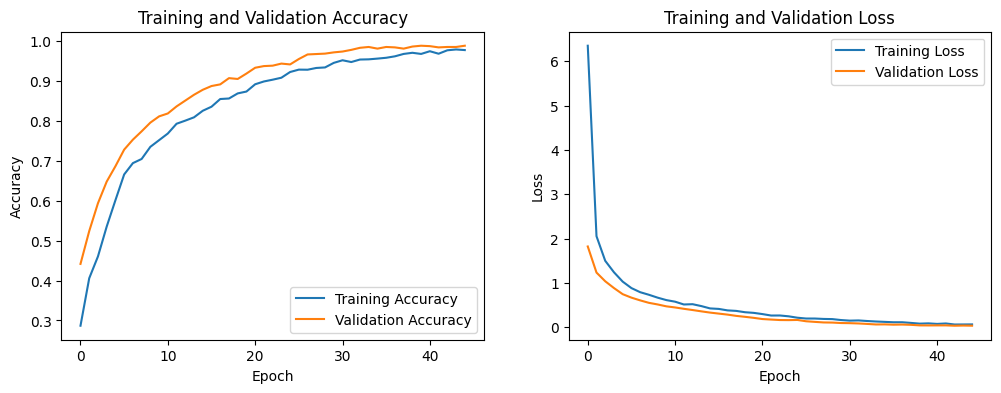

In [22]:
#  Visualize accuracy and loss plot
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss         = history.history['loss']
val_loss     = history.history['val_loss']

plt.figure(figsize = (12, 4))
epochs = range(len(accuracy))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [23]:
class_names = train_generator.class_names
class_indices = dict(zip(class_names, range(len(class_names))))

print(class_indices)

{'Alternaria': 0, 'Anthracnose': 1, 'Black Mould Rot': 2, 'Healthy': 3, 'Stem end Rot': 4}


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


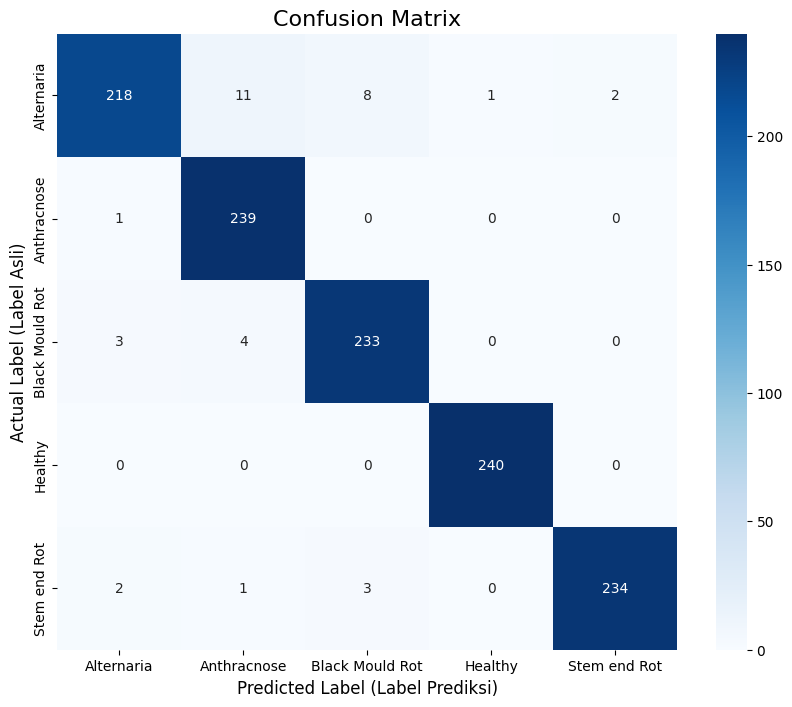

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_probs = model_layer.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for images, labels in test_generator:
  y_true.extend(labels.numpy())
y_true = np.array(y_true)

class_names = test_generator.class_names
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label (Label Asli)', fontsize=12)
plt.xlabel('Predicted Label (Label Prediksi)', fontsize=12)
plt.show()

# TRIALS

Saving pngtree-rotten-mango-fruit-isolated-png-image_10127317.png to pngtree-rotten-mango-fruit-isolated-png-image_10127317.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
pngtree-rotten-mango-fruit-isolated-png-image_10127317.png
Alternaria 0.1012
Anthracnose 0.0704
Black Mould Rot 0.0048
Healthy 0.0002
Stem end Rot 0.8234


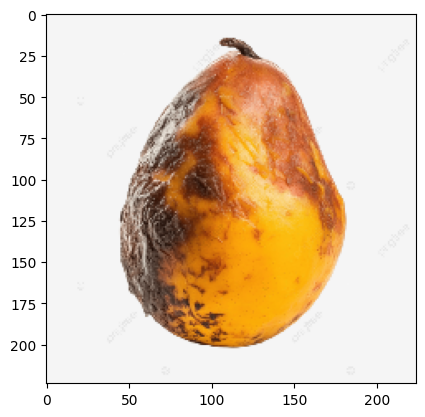

In [26]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(224, 224))

  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model_layer.predict(images, batch_size=8)
  print(fn)

  print('Alternaria', '{:.4f}'.format(classes[0,0]))
  print('Anthracnose', '{:.4f}'.format(classes[0,1]))
  print('Black Mould Rot', '{:.4f}'.format(classes[0,2]))
  print('Healthy', '{:.4f}'.format(classes[0,3]))
  print('Stem end Rot', '{:.4f}'.format(classes[0,4]))

In [27]:
import os

file_size = os.path.getsize('model_mangga_VGG16.keras') / (1024 * 1024) # Konversi ke MB

print(f"Ukuran file model Anda adalah: {file_size:.2f} MB")

Ukuran file model Anda adalah: 167.68 MB
